In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import scipy

Part 1: Data Wrangling
===

In [2]:
# load data from csv
data = pd.read_csv('../data/Spotify-2000.csv')

# convert Length (Duration) column to int64 and relabel with units
data['Length (Duration)'] = data['Length (Duration)'].str.replace(",", "")
data['Length (Duration)'] = data['Length (Duration)'].astype('int64')
data = data.rename(columns={'Length (Duration)': 'Duration (Seconds)'})

# display summary information
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Index                   1994 non-null   int64 
 1   Title                   1994 non-null   object
 2   Artist                  1994 non-null   object
 3   Top Genre               1994 non-null   object
 4   Year                    1994 non-null   int64 
 5   Beats Per Minute (BPM)  1994 non-null   int64 
 6   Energy                  1994 non-null   int64 
 7   Danceability            1994 non-null   int64 
 8   Loudness (dB)           1994 non-null   int64 
 9   Liveness                1994 non-null   int64 
 10  Valence                 1994 non-null   int64 
 11  Duration (Seconds)      1994 non-null   int64 
 12  Acousticness            1994 non-null   int64 
 13  Speechiness             1994 non-null   int64 
 14  Popularity              1994 non-null   int64 
dtypes: i

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Duration (Seconds),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59


Part 2: Exploratory Data Analysis
===

In [3]:
# create dictionary of word frequency in genre
categories = {}
for genre in data['Top Genre']:
    words = genre.split(' ')
    for word in words:
        if word in categories:
            categories[word] += 1
        else:
            categories[word] = 1

# sort dictionary by frequency to get most common overall genre categories
list({k: v for k, v in sorted(categories.items(), key=lambda item: item[1], reverse=True)}.items())[:8]

[('rock', 856),
 ('album', 413),
 ('pop', 344),
 ('dutch', 266),
 ('alternative', 187),
 ('dance', 151),
 ('adult', 123),
 ('standards', 123)]

In [4]:
# label data with the selected genre categories
for i, row in data.iterrows():
    if "pop" in row['Top Genre']: 
        data.at[i,'Genre Classification'] = 2
    elif "rock" in row['Top Genre']:
        data.at[i,'Genre Classification'] = 1
    else: 
        data.at[i,'Genre Classification'] = 0

# TODO: Deal with pop rock and metal 

# display
data.head(8)

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Duration (Seconds),Acousticness,Speechiness,Popularity,Genre Classification
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201,94,3,71,0.0
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207,17,7,39,1.0
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341,2,17,69,0.0
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269,0,4,76,0.0
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256,1,3,59,1.0
5,6,The Road Ahead (Miles Of The Unknown),City To City,alternative pop rock,2004,99,46,54,-9,14,14,247,0,2,45,2.0
6,7,She Will Be Loved,Maroon 5,pop,2002,102,71,71,-6,13,54,257,6,3,74,2.0
7,8,Knights of Cydonia,Muse,modern rock,2006,137,96,37,-5,12,21,366,0,14,69,1.0


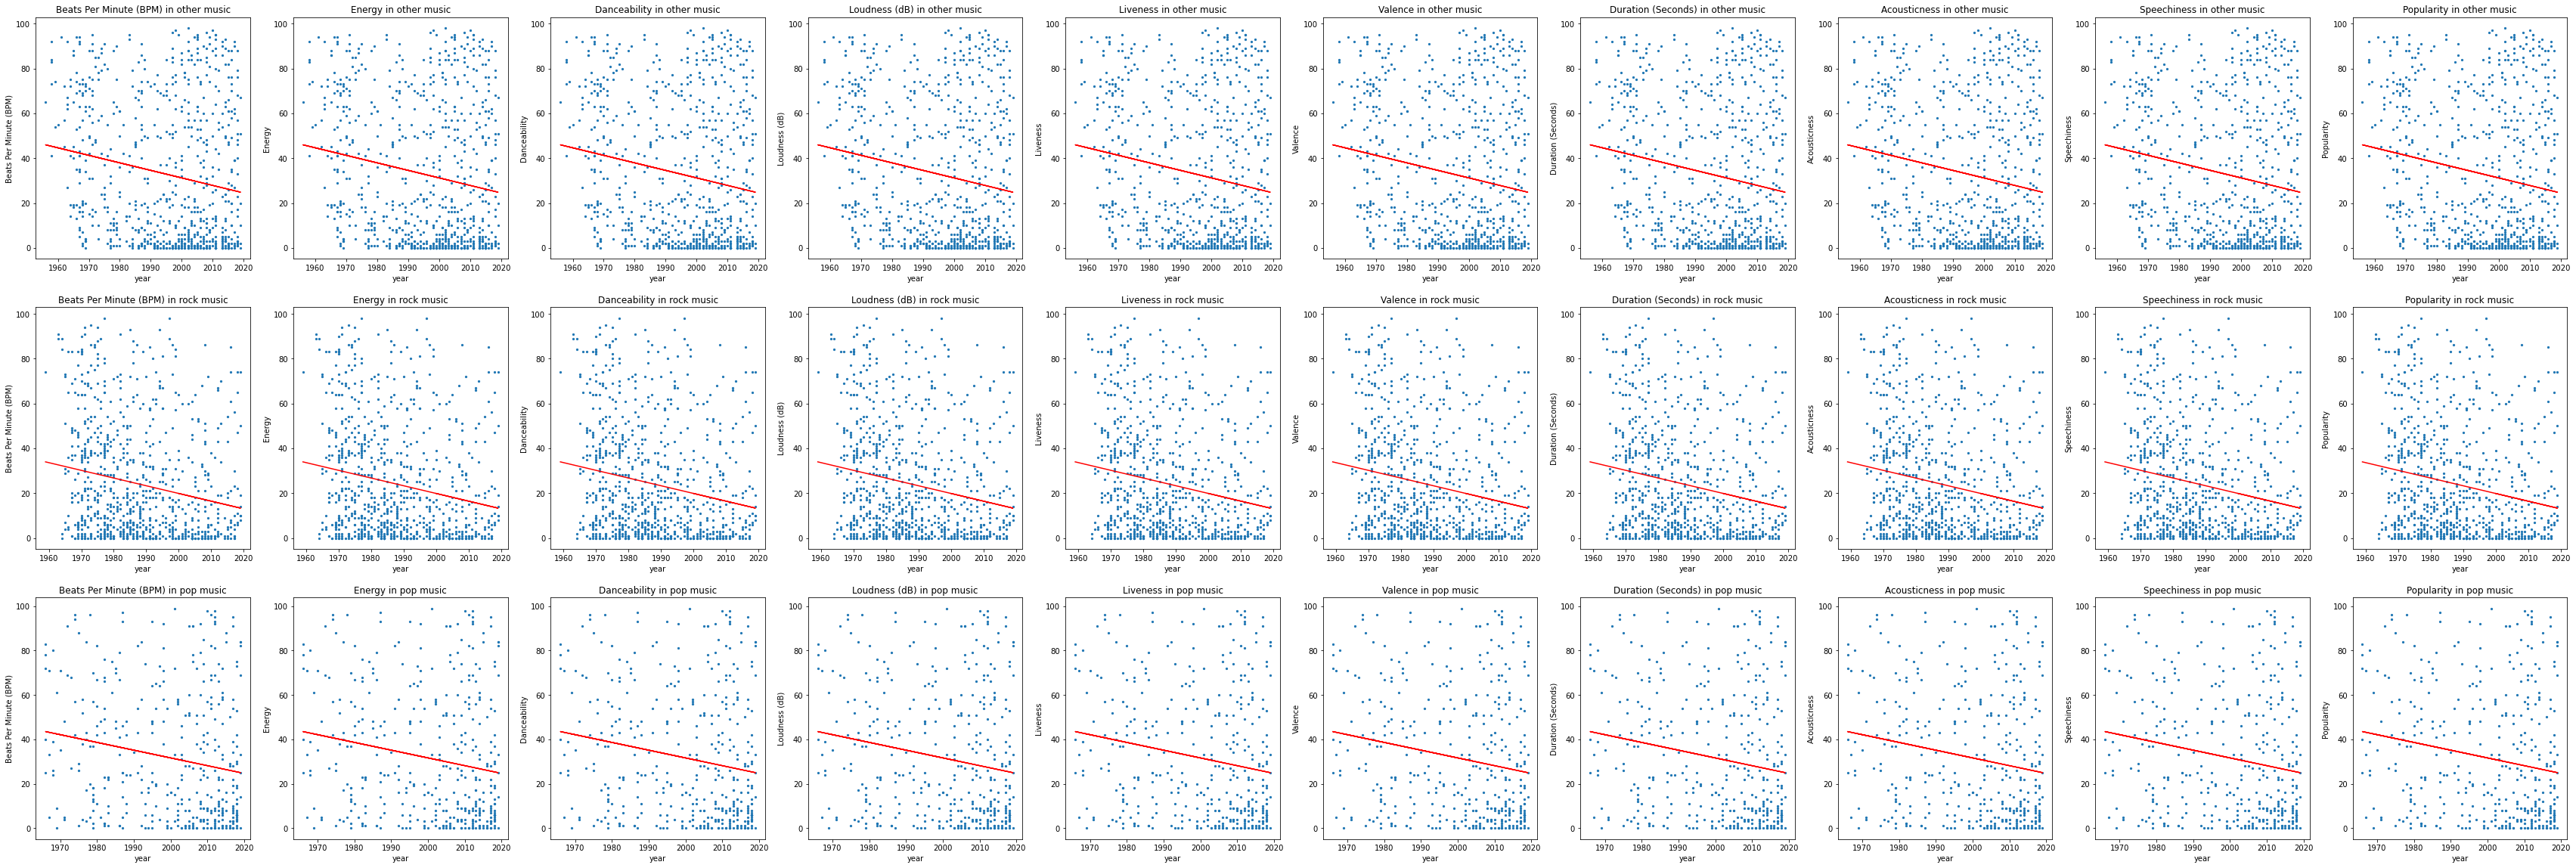

In [9]:
features = data.columns[5:15]
fig, ax = plt.subplots(3,10,figsize=(60,20))
# plt.subplots_adjust(hspace=1.2)
for i, feature in enumerate(features):

    for genre in range(0,3):
        lm = linear_model.LinearRegression()

        frame = data[data['Genre Classification'] == genre]
        x = pd.DataFrame(frame['Year'])
        y = pd.DataFrame(frame['Acousticness'])

        lm.fit(x,y)

        ax[genre, i].scatter(x,y,s=5)

        genre_name =''
        if genre == 2.0:
            genre_name = "pop"
        elif genre == 1.0:
            genre_name = "rock"
        else:
            genre_name = "other"

        ax[genre, i].set_xlabel("year")
        ax[genre, i].set_ylabel(feature)
        ax[genre, i].set_title(f'{feature} in {genre_name} music')

        ax[genre, i].plot(x, lm.predict(x), color='red')